In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netpyne import sim, specs

%matplotlib inline

savedata = 1 # Save Netpyne and BBP soma_voltage

--No graphics will be displayed.


In [2]:
!nrnivmodl mod/

/opt/miniconda3/envs/netpyne/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/usr/bin/xcrun
/Users/tarek/Desktop/HL23PYR_AD
Mod files: "mod/mod//CaDynamics.mod" "mod/mod//Ca_HVA.mod" "mod/mod//Ca_LVA.mod" "mod/mod//Gfluct.mod" "mod/mod//Ih.mod" "mod/mod//Im.mod" "mod/mod//K_P.mod" "mod/mod//K_T.mod" "mod/mod//Kv3_1.mod" "mod/mod//NMDA.mod" "mod/mod//NaTg.mod" "mod/mod//Nap.mod" "mod/mod//ProbAMPANMDA.mod" "mod/mod//ProbUDFsyn.mod" "mod/mod//SK.mod" "mod/mod//epsp.mod" "mod/mod//tonic.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.dylib
Successfully created x86_64/special


# **CONFIGURATION**

In [3]:
cfg = specs.SimConfig()

cfg.duration = 2350  # Total simulation time (ms)
cfg.dt = 0.025       # Integration step (ms)
cfg.seeds = {'cell': 4321, 'conn': 4321, 'stim': 1234, 'loc':4321}  
cfg.hParams = {'celsius': 34, 'v_init': -80}  
cfg.verbose = False
cfg.createNEURONObj = True
cfg.createPyStruct = True
cfg.cvode_active = False
cfg.cache_efficient = True

cfg.recordCells = ['HL23PYR_{}'.format(i) for i in range(1, 16)]  # Recording from all populations
cfg.recordTraces = {'V_soma': {'sec': 'soma_0', 'loc': 0.5, 'var': 'v'}}
cfg.recordStim = True
cfg.recordTime = True
cfg.recordStep = 0.025

cfg.simLabel = 'L23_Pyr'
cfg.saveFolder = '.'
cfg.savePickle = False
cfg.saveJson = False

# **NETWORK PARAMETERS**

In [4]:
netParams = specs.NetParams()

cellName = 'HL23PYR'
netParams.importCellParams(
    label=cellName, 
    conds={'cellType': cellName, 'cellModel': 'HH_full'},
    fileName='cellwrapper.py',  
    cellName='loadCell_' + cellName,
    cellInstance=True,
    cellArgs={'cellName': cellName}
)

# Ensure soma section exists
if 'soma_0' not in netParams.cellParams[cellName]['secs']:
    raise ValueError("ERROR: 'soma_0' section is missing from imported neuron!")

NeuronTemplate_HL23PYR[0]
Kv3.1 gbar (soma): 0.0424
SK gbar (soma): 0.000853
NaTg gbar (axon): 1.38
Nap gbar (axon): 0.00842


# *Add Background Excitatory Synaptic Input*

In [5]:
# netParams.stimSourceParams['exc_bg'] = {
#     'type': 'NetStim',
#     'rate': 2000,  # Hz, controls the frequency of random excitatory synapses
#     'start': 0, 
#     'noise': 1.0  # 1.0 means Poisson-distributed spike times
# }

# netParams.stimTargetParams['exc_bg->HL23PYR'] = {
#     'source': 'exc_bg', 
#     'conds': {'pop': 'HL23PYR'},
#     'sec': 'soma_0', 
#     'loc': 0.5, 
#     'weight': 0.001,  # Synaptic weight (adjust this!)
#     'delay': 1,
#     'synMech': 'AMPA'  # Use an AMPA-like mechanism
# }


# *Add Background Inhibitory Synaptic Input*

In [6]:
# netParams.stimSourceParams['inh_bg'] = {
#     'type': 'NetStim',
#     'rate': 1000,  # Hz, inhibitory input rate
#     'start': 0, 
#     'noise': 1.0
# }

# netParams.stimTargetParams['inh_bg->HL23PYR'] = {
#     'source': 'inh_bg', 
#     'conds': {'pop': 'HL23PYR'},
#     'sec': 'soma_0', 
#     'loc': 0.5, 
#     'weight': 0.002,  # Typically stronger than AMPA
#     'delay': 1,
#     'synMech': 'GABA'  # Use a GABA-like mechanism
# }


# **POPULATIONS & CURRENT INJECTIONS**

In [7]:
allpops = ['HL23PYR_{}'.format(i) for i in range(1, 16)]

for popName in allpops:
    netParams.popParams[popName] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': 1}

cfg.IClamp = []
current_start = -0.3  # Initial current (nA)
current_end = 0.4  # Final current (nA)
current_step = 0.050  # Step size (nA)

# Define stimulation
cfg.IClampnumber = 0
for i, popName in enumerate(allpops):
    amp = current_start + i * current_step
    cfg.IClamp.append({'pop': popName, 'sec': 'soma_0', 'loc': 0.5, 'start': 1200, 'dur': 800, 'amp': amp})  
    cfg.IClampnumber += 1

# Assign stimulation to each population
for j in range(cfg.IClampnumber):
    key = 'IClamp{}'.format(j+1)
    params = cfg.IClamp[j]
    pop, sec, loc, start, dur, amp = params['pop'], params['sec'], params['loc'], params['start'], params['dur'], params['amp']
    
    netParams.stimSourceParams[key] = {'type': 'IClamp', 'delay': start, 'dur': dur, 'amp': amp}
    netParams.stimTargetParams[key+'_'+pop] = {'source': key, 'conds': {'pop': pop}, 'sec': sec, 'loc': loc}

# **RUN SIMULATION**

In [8]:
sim.initialize(simConfig=cfg, netParams=netParams)
sim.net.createPops()
sim.net.createCells()
sim.net.connectCells()
sim.net.addStims()
sim.setupRecording()

sim.runSim()                      			# run parallel Neuron simulation  
sim.gatherData()                  			# gather spiking data and cell info from each node
sim.saveData()                    			# save params, cell info and sim output to file (pickle,mat,txt,etc)#
sim.analysis.plotData()         			# plot spike raster etc
sim.analysis.plotShape()  


Start time:  2025-03-31 20:29:13.000732

Creating network of 15 cell populations on 1 hosts...
  Number of cells on node 0: 15 
  Done; cell creation time = 0.38 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
Adding stims...
  Number of stims on node 0: 15 
  Done; cell stims creation time = 0.00 s.
Recording 30 traces of 2 types on node 0

Running simulation using NEURON for 2350.0 ms...
  Done; run time = 42.29 s; real-time ratio: 0.06.

Gathering data...
  Done; gather time = 0.23 s.

Analyzing...
  Cells: 15
  Connections: 0 (0.00 per cell)
  Spikes: 102 (2.89 Hz)
  Simulated time: 2.4 s; 1 workers
  Run time: 42.29 s
  Done; plotting time = 0.00 s

Total time = 42.91 s
Plotting 3D cell shape ...


(<Figure size 640x480 with 1 Axes>, {})

In [9]:
# dir(sim)

In [10]:
# sim.allSimData.keys()  # Check what data is available

In [11]:
# print("Spike times:", sim.allSimData['spkt'][:10])  # First 10 spike times
# print("Neuron IDs:", sim.allSimData['spkid'][:10])  # First 10 neuron IDs

In [12]:
# if 'V_soma' in sim.simData:
#     print("Voltage trace keys:", sim.simData['V_soma'].keys())


In [13]:
# if 'I_injected' in sim.allSimData:
#     print("Injected currents:", sim.allSimData['I_injected'])

In [14]:
# print(dir(sim.net.cells[0]))  # Check available attributes in the first simulated neuron

In [15]:
# print(cfg.recordTraces)  # Check what variables were set for recording

In [16]:
# print(netParams.stimSourceParams)  # Look for current injection settings

In [17]:
# for cell in sim.net.cells:
#     print(cell.stims)  # Check stimulation applied to each cell

In [18]:
# print(f"Type of sim.simData['t']: {type(sim.simData['t'])}")
# print(f"Contents of sim.simData['t']: {sim.simData['t']}")


In [19]:
# import numpy as np

# # If time is missing, reconstruct it manually
# time = np.arange(0, cfg.duration, cfg.dt)
# print(f"Reconstructed time array (first 10 values): {time[:10]}")


# **ANALYSIS: Firing Rate Calculation**

In [20]:
# Extract firing rate
spk_times = sim.simData['spkt']  # Tempos de spikes
spk_ids = sim.simData['spkid']  # IDs dos neurônios

steps, rates = np.unique(spk_ids, return_counts=True)

# **PLOT: F-I Curve**

In [21]:
from scipy.stats import linregress

# Ensure current_start is correctly defined before running regression
current_start = -0.30  # nA (example, adjust as needed)
current_step = 0.050  # nA step

# Compute linear regression on the F-I curve
slope, intercept, r_value, p_value, std_err = linregress(current_start + steps * current_step, rates / 0.8)

print(f"F-I Curve Slope: {slope:.3f} Hz/nA")
print(f"Intercept: {intercept:.3f} Hz")
print(f"R-squared: {r_value**2:.3f}")


F-I Curve Slope: 44.643 Hz/nA
Intercept: 7.054 Hz
R-squared: 0.995


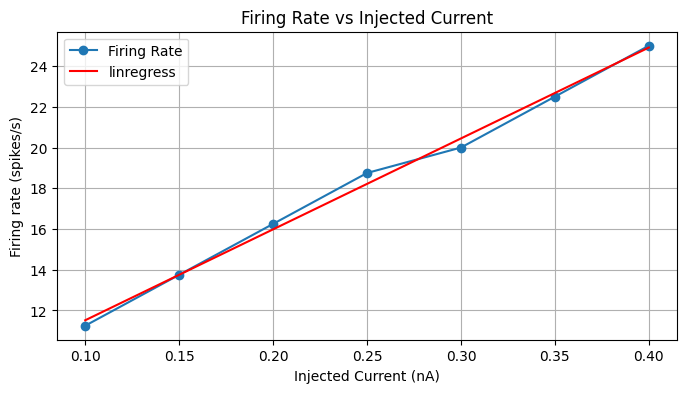

In [22]:
# Plot
plt.figure(figsize=(8, 4))
plt.plot(current_start + steps * current_step, rates/0.8, marker='o', label='Firing Rate')
plt.plot([0.1,0.4],[7.054 + 0.1*44.643, 7.054 + 0.4*44.643],'r', label='linregress')
plt.xlabel('Injected Current (nA)')
plt.ylabel('Firing rate (spikes/s)')
plt.title('Firing Rate vs Injected Current')
plt.grid(True)
plt.legend()
plt.show()


In [23]:
import numpy as np

# Extract spike times and IDs
spike_times = np.array(sim.simData['spkt'])  # Spike times
spike_ids = np.array(sim.simData['spkid'])  # Corresponding cell IDs

# Define current steps 
current_steps = np.arange(-300, 400, 50)  # pA

# Identify the first current step that reliably produces a spike
for i, current in enumerate(current_steps):
    spikes_at_current = np.any(spike_ids == i)  # Check if any cell spikes at this current
    if spikes_at_current:
        rheobase = current
        break

print(f"Rheobase: {rheobase} pA")


Rheobase: 100 pA


# **PLOT: V-I Curve (Sag)**

In [24]:
# Compute Sag Values for each cell
sag_values = []

for cell in sim.simData['V_soma']:
    V_soma = np.array(sim.simData['V_soma'][cell])  # Convert to NumPy array
    t = np.array(sim.simData['t'])  # Time array

    # Define hyperpolarization window
    V_min = V_soma[(t >= 1200) & (t < 2000)].min()  # Minimum voltage during hyperpolarization
    V_ss = V_soma[t <= 2000][-1]  # Steady-state voltage

    sag = V_ss - V_min
    sag_values.append(sag)

# Now `sag_values` exists, so you can iterate over it
for i, amp in enumerate(np.linspace(-0.300, 0.0, 6)):
    print(f"Injected Current: {amp:.3f} nA | Sag: {sag_values[i]:.3f} mV")


Injected Current: -0.300 nA | Sag: 3.197 mV
Injected Current: -0.240 nA | Sag: 2.450 mV
Injected Current: -0.180 nA | Sag: 1.777 mV
Injected Current: -0.120 nA | Sag: 1.190 mV
Injected Current: -0.060 nA | Sag: 0.700 mV
Injected Current: 0.000 nA | Sag: 0.308 mV


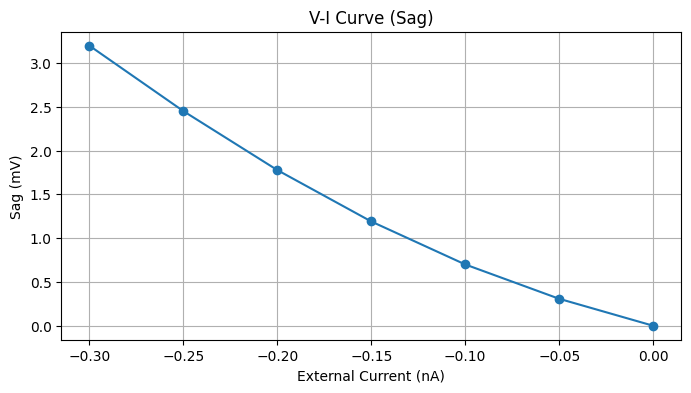

In [25]:
plt.figure(figsize=(8, 4))
plt.grid(True)

plt.plot(np.linspace(-0.300, 0.0, 7), sag_values[0:7], 'o-')

plt.ylabel('Sag (mV)')
plt.xlabel('External Current (nA)')
plt.title("V-I Curve (Sag)")
plt.grid(True)
plt.show()


# **PLOT: Voltage Traces**

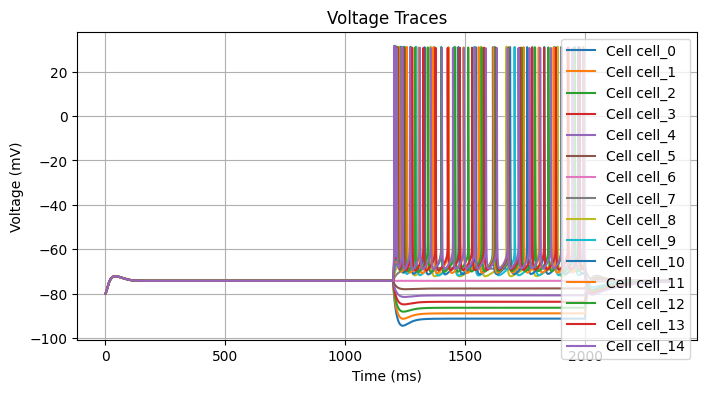

In [35]:
plt.figure(figsize=(8, 4))
for cellName in sim.simData['V_soma'].keys():
    plt.plot(sim.simData['t'], sim.simData['V_soma'][cellName], label=f"Cell {cellName}")

plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.title('Voltage Traces')
plt.legend()
plt.grid(True)
plt.show()

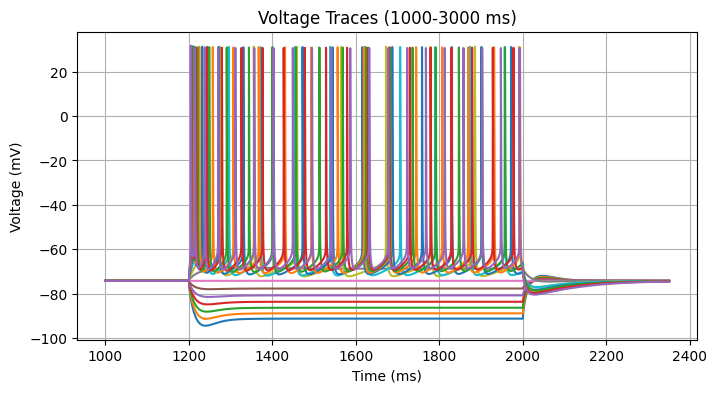

In [36]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 4))

# Define time range
start_time, end_time = 1000, 3000

# Convert time array to NumPy for indexing
time_array = np.array(sim.simData['t'])

# Find indices corresponding to the desired time range
time_indices = np.where((time_array >= start_time) & (time_array <= end_time))

# Plot voltage traces for all cells in the given time range
for cellName in sim.simData['V_soma'].keys():
    plt.plot(time_array[time_indices], np.array(sim.simData['V_soma'][cellName])[time_indices], label=f"Cell {cellName}")

plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.title(f'Voltage Traces ({start_time}-{end_time} ms)')
# plt.legend()
plt.grid(True)
plt.show()


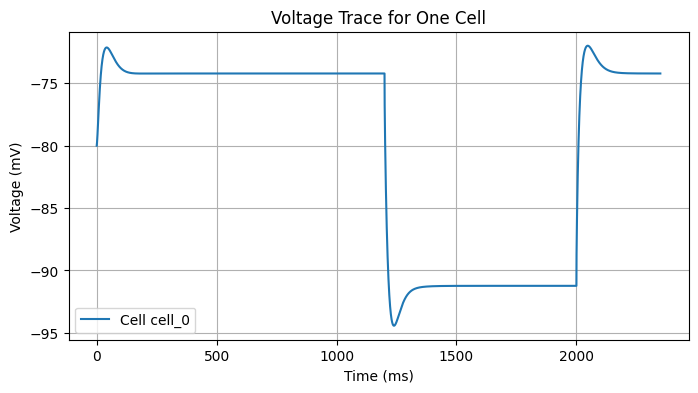

In [37]:
plt.figure(figsize=(8, 4))
cellName = list(sim.simData['V_soma'].keys())[0]  # Select the first cell
plt.plot(sim.simData['t'], sim.simData['V_soma'][cellName], label=f"Cell {cellName}")
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.title('Voltage Trace for One Cell')
plt.legend()
plt.grid(True)
plt.show()


# ***PHYSIOLOGICAL PROPERTIES EFEL: https://efel.readthedocs.io/en/latest/eFeatures.html ***

In [38]:
# !pip install efel
import efel

(1000.0, 2200.0)

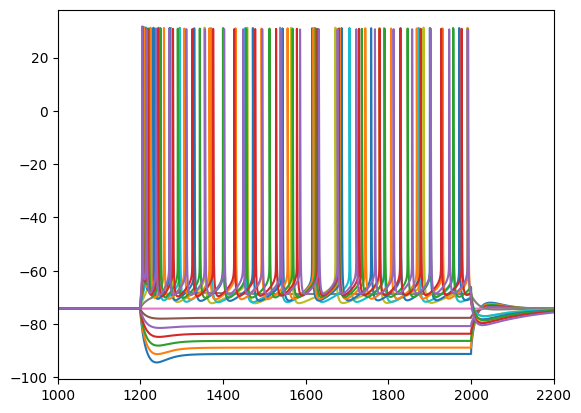

In [39]:
traces = []
for cellName in sim.simData['V_soma'].keys():
    plt.plot(sim.simData['t'], sim.simData['V_soma'][cellName], label=f"Cell {cellName}")

    trace = {}
    trace['T'] = sim.simData['t']
    trace['V'] = sim.simData['V_soma'][cellName]
    trace['stim_start'] = [1200.0]
    trace['stim_end'] = [2000.0]
    traces.append(trace)

plt.xlim(1000,2200)

In [47]:
feature_items = ['sag_amplitude', 'steady_state_voltage_stimend','spike_count','mean_frequency', 'ISI_CV', 'time_to_first_spike', 'time_to_second_spike', 'AP_height', 'AP_width', 'AP_duration_half_width', 'AP_amplitude']
feature_values = efel.get_feature_values(traces, feature_items)
feature_values[0], '  ', feature_values[-1]
attributes = dir(feature_values)
print(attributes)

['__add__', '__class__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rmul__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'append', 'clear', 'copy', 'count', 'extend', 'index', 'insert', 'pop', 'remove', 'reverse', 'sort']


In [45]:
# feature_values[0], '  ', feature_values[-1]

NameError: name 'feature_values' is not defined

In [42]:
# attributes = dir(feature_values)
# print(attributes)

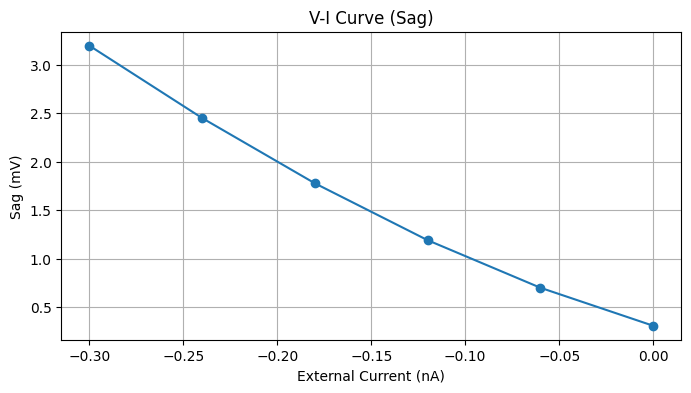

In [48]:
# Compute Sag Values for each cell
sag_values = []

for step_number in range(0,6):
    sag_values.append(feature_values[step_number]['sag_amplitude'])

plt.figure(figsize=(8, 4))
plt.grid(True)
plt.plot(np.linspace(-0.300, 0.0, 6), sag_values[0:6], 'o-')

plt.ylabel('Sag (mV)')
plt.xlabel('External Current (nA)')
plt.title("V-I Curve (Sag)")
plt.grid(True)
plt.show()


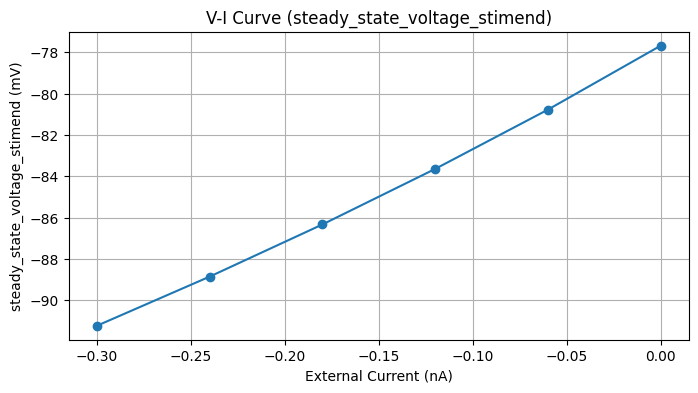

In [49]:
# Compute steady_state_voltage_stimend Values for each cell
values = []

for step_number in range(0,6):
    values.append(feature_values[step_number]['steady_state_voltage_stimend'])

plt.figure(figsize=(8, 4))
plt.grid(True)
plt.plot(np.linspace(-0.300, 0.0, 6), values[0:6], 'o-')

plt.ylabel('steady_state_voltage_stimend (mV)')
plt.xlabel('External Current (nA)')
plt.title("V-I Curve (steady_state_voltage_stimend)")
plt.grid(True)
plt.show()


In [55]:
# # Compute AP_duration_half_width Values for each cell
# values = []
# values_mean = []
# values_std = []

# plt.figure(figsize=(8, 4))
# plt.grid(True)

# for step_number in range(8,15):
#     values.append(feature_values[step_number]['AP_duration_half_width'][0]) # first
#     values_mean.append(np.mean(feature_values[step_number]['AP_duration_half_width']))
#     values_std.append(np.std(feature_values[step_number]['AP_duration_half_width']))

#     plt.plot(np.zeros(len(feature_values[step_number]['AP_duration_half_width'])) + -0.30+step_number*0.05,feature_values[step_number]['AP_duration_half_width'], 'ro')

# plt.errorbar(np.linspace(0.100, 0.4, 7), values_mean[0:7], yerr=values_std[0:7],  color='b', ecolor='b', label="Mean ± Std Dev", elinewidth = 2.0)
# plt.ylabel('AP_duration_half_width (ms)')
# plt.xlabel('External Current (nA)')
# plt.title("AP_duration_half_width")
# plt.grid(True)
# plt.show()


In [54]:
# # Compute AP_amplitude Values for each cell
# values = []
# values_mean = []
# values_std = []

# plt.figure(figsize=(8, 4))
# plt.grid(True)

# for step_number in range(8,15):
#     values.append(feature_values[step_number]['AP_amplitude'][0]) # first
#     values_mean.append(np.mean(feature_values[step_number]['AP_amplitude']))
#     values_std.append(np.std(feature_values[step_number]['AP_amplitude']))

#     plt.plot(np.zeros(len(feature_values[step_number]['AP_amplitude'])) + -0.30+step_number*0.05,feature_values[step_number]['AP_amplitude'], 'ro')

# plt.errorbar(np.linspace(0.100, 0.4, 7), values_mean[0:7], yerr=values_std[0:7],  color='b', ecolor='b', label="Mean ± Std Dev", elinewidth = 2.0)
# plt.ylabel('AP_amplitude (ms)')
# plt.xlabel('External Current (nA)')
# plt.title("AP_amplitude")
# plt.grid(True)
# plt.show()


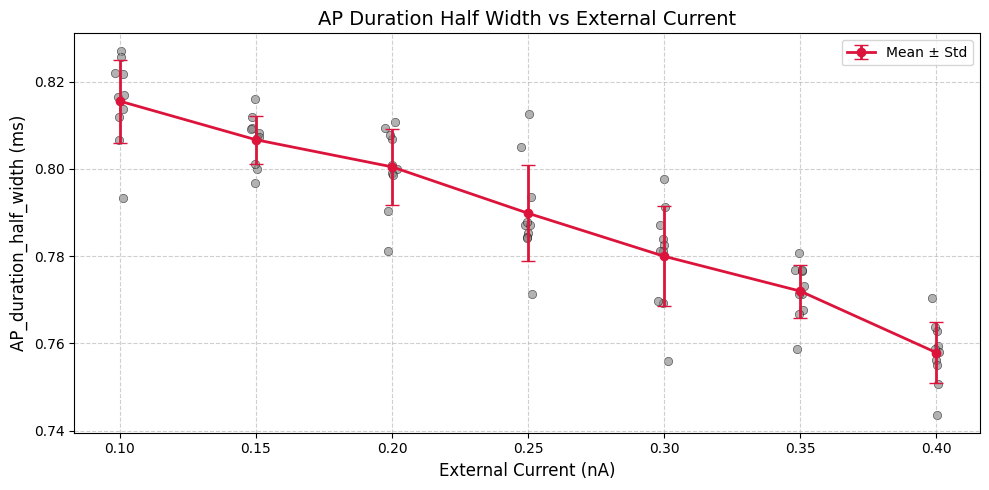

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Replace this simulated block with your actual feature_values
feature_values = {
    i: {'AP_duration_half_width': np.random.normal(loc=0.9 - 0.01*i, scale=0.01, size=10)} 
    for i in range(8, 15)
}

# Extract values
current_values = [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40]
all_data = [feature_values[i]['AP_duration_half_width'] for i in range(8, 15)]
means = [np.mean(data) for data in all_data]
stds = [np.std(data) for data in all_data]

# Plot
fig, ax = plt.subplots(figsize=(10, 5))

# Jittered scatter for individual datapoints
for i, (x, y_vals) in enumerate(zip(current_values, all_data)):
    jitter = np.random.normal(loc=0, scale=0.001, size=len(y_vals))
    ax.scatter([x + j for j in jitter], y_vals, color='gray', alpha=0.6, edgecolor='black', linewidth=0.5)

# Mean ± Std line
ax.errorbar(current_values, means, yerr=stds, fmt='-o', color='crimson', linewidth=2, capsize=5, label='Mean ± Std')

# Labels and styling
ax.set_title('AP Duration Half Width vs External Current', fontsize=14)
ax.set_xlabel('External Current (nA)', fontsize=12)
ax.set_ylabel('AP_duration_half_width (ms)', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()
plt.tight_layout()
plt.show()


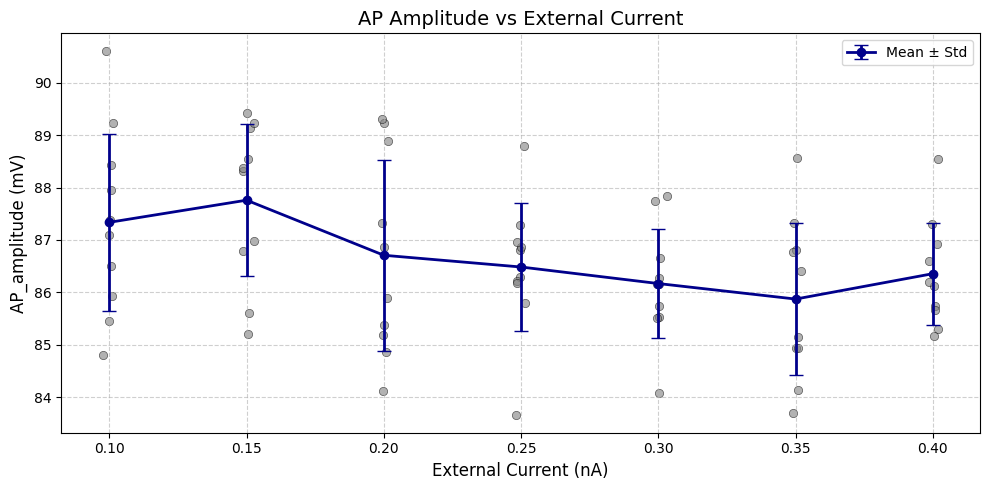

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Example mock structure (replace with your actual feature_values)
feature_values = {
    i: {'AP_amplitude': np.random.normal(loc=90 - i*0.3, scale=1.2, size=10)}
    for i in range(8, 15)
}

# Extract data
current_values = [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40]
all_data = [feature_values[i]['AP_amplitude'] for i in range(8, 15)]
means = [np.mean(data) for data in all_data]
stds = [np.std(data) for data in all_data]

# Plot
fig, ax = plt.subplots(figsize=(10, 5))

# Jittered scatter
for i, (x, y_vals) in enumerate(zip(current_values, all_data)):
    jitter = np.random.normal(loc=0, scale=0.001, size=len(y_vals))
    ax.scatter([x + j for j in jitter], y_vals, color='gray', alpha=0.6, edgecolor='black', linewidth=0.5)

# Mean ± Std
ax.errorbar(current_values, means, yerr=stds, fmt='-o', color='darkblue', linewidth=2, capsize=5, label='Mean ± Std')

# Labels and styling
ax.set_title('AP Amplitude vs External Current', fontsize=14)
ax.set_xlabel('External Current (nA)', fontsize=12)
ax.set_ylabel('AP_amplitude (mV)', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()
plt.tight_layout()
plt.show()
